In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt


In [2]:
ls

CFRC_Amazon.ipynb        bookDataset/             movies_history.pkl
CFRC_Books-2.ipynb       books_history.pkl        movies_history_1.pkl
CFRC_Books.ipynb         books_history_1.pkl      movies_history_2.pkl
CFRC_BooksF.ipynb        books_history_2.pkl      movies_logs/
CFRC_Movies.ipynb        books_logs/              prepdata.py
CFRC_MoviesF.ipynb       makeRec.py               ratings_Electronics.csv
ExploringData.ipynb      ml-latest-small/         recmodel.py
__pycache__/             model01.h5


# First, load the data and apply preprocessing

In [3]:
from prepdata import load

In [4]:
import os
#movie dir holds both  ratings.csv and movies.csv
movies_dir = os.path.abspath(os.path.abspath("ml-latest-small"))

In [5]:
df, movies_df = load("movies", movies_dir)

- itemId reperesent "movie id" in this notebook

In [6]:
df

,userId,itemId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [12]:
from prepdata import createList, formatData

In [13]:
user = createList(df, pram= 'user')
item = createList(df, pram= 'item')

In [14]:
num_users, num_items = formatData(df, user,item)

Number of users: 610, Number of Books: 9724, Min rating: 0.5, Max rating: 5.0


In [15]:
df

,userId,itemId,rating,user,item
0,1,1,4.0,0,0
1,1,3,4.0,0,1
2,1,6,4.0,0,2
3,1,47,5.0,0,3
4,1,50,5.0,0,4
...,...,...,...,...,...
100831,610,166534,4.0,609,3120
100832,610,168248,5.0,609,2035
100833,610,168250,5.0,609,3121
100834,610,168252,5.0,609,1392


# Prepare training and validation data

In [16]:
from prepdata import prepData

In [17]:
x_train, x_val, y_train, y_val = prepData(df)

# Create the model

We embed both users and movies in to 50-dimensional vectors.

The model computes a match score between user and movie embeddings via a dot product, and adds a per-movie and per-user bias. The match score is scaled to the [0, 1] interval via a sigmoid (since our ratings are normalized to this range).

In [37]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_items, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)


Metal device set to: Apple M1 Pro


2022-05-06 02:01:35.927133: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-06 02:01:35.927358: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/citlallylopez/miniforge3/envs/mbp/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Train the model based on the data split

In [13]:
#saving checkoints
from keras.callbacks import ModelCheckpoint

#issue: unable to use due to subclassed model
checkpoint = ModelCheckpoint('movies_logs/model2{epoch:02d}.h5', monitor='loss', verbose=1,
     save_best_only=True, mode='auto', save_freq='epoch', save_weights_only=True)

In [14]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=10,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint]
)


Epoch 1/10
1414/1418 [============================>.] - ETA: 0s - loss: 0.6068
Epoch 1: loss improved from inf to 0.60675, saving model to movies_logs/model201.h5
1418/1418 [==============================] - 17s 12ms/step - loss: 0.6068 - val_loss: 0.6145
Epoch 2/10
1417/1418 [============================>.] - ETA: 0s - loss: 0.6063
Epoch 2: loss improved from 0.60675 to 0.60633, saving model to movies_logs/model202.h5
1418/1418 [==============================] - 16s 11ms/step - loss: 0.6063 - val_loss: 0.6118
Epoch 3/10
1415/1418 [============================>.] - ETA: 0s - loss: 0.6061
Epoch 3: loss improved from 0.60633 to 0.60614, saving model to movies_logs/model203.h5
1418/1418 [==============================] - 16s 11ms/step - loss: 0.6061 - val_loss: 0.6119
Epoch 4/10
1414/1418 [============================>.] - ETA: 0s - loss: 0.6053
Epoch 4: loss improved from 0.60614 to 0.60533, saving model to movies_logs/model204.h5
1418/1418 [==============================] - 16s 12ms/ste

### Load and save history

In [15]:
import pickle
# Save train  loss history - changes previous history if trained before
pickle.dump(history, open('movies_history_2.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://18e122f8-a00d-452c-83b8-f5a70c120088/assets


In [40]:
#if training before, input old history
with open('movies_history_2.pkl', 'rb') as f:
    h = pickle.load(f)

In [41]:
h.history

{'loss': [0.6067537069320679,
  0.6063300967216492,
  0.6061434745788574,
  0.6053253412246704,
  0.6051957607269287,
  0.6045538187026978,
  0.6044831871986389,
  0.6058639287948608,
  0.6048643589019775,
  0.6050958037376404],
 'val_loss': [0.6145461201667786,
  0.6117705702781677,
  0.6119254231452942,
  0.6115807890892029,
  0.613374650478363,
  0.614518940448761,
  0.6122536659240723,
  0.6133273243904114,
  0.613095223903656,
  0.6129983067512512]}

# Plot training and validation loss

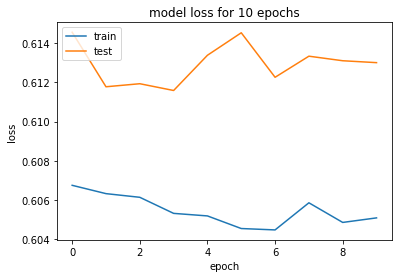

In [42]:
#third attempt - 10 epochs found in 'movies_history_2.pkl'
plt.plot(h.history["loss"])
plt.plot(h.history["val_loss"])
plt.title("model loss for 10 epochs")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


In [43]:
#if training before, input old history
with open('movies_history_1.pkl', 'rb') as f:
    h = pickle.load(f)

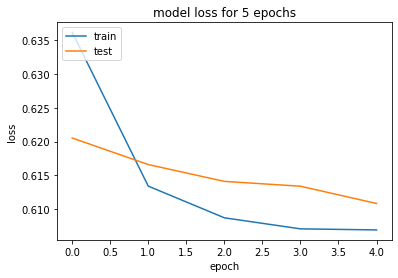

In [44]:
#second attempt - 5 epochs found in movies_history_1.pkl'
plt.plot(h.history["loss"])
plt.plot(h.history["val_loss"])
plt.title("model loss for 5 epochs")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


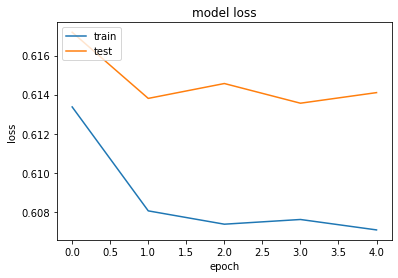

In [11]:
#first attempt - 5 epochs found in 'movies_history.pkl'
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


# Show top 10 movie recommendations to a user

In [18]:
# error with function import
from makeRec import showRecommendation

In [26]:
df

,userId,itemId,rating,user,item
0,1,1,4.0,0,0
1,1,3,4.0,0,1
2,1,6,4.0,0,2
3,1,47,5.0,0,3
4,1,50,5.0,0,4
...,...,...,...,...,...
100831,610,166534,4.0,609,3120
100832,610,168248,5.0,609,2035
100833,610,168250,5.0,609,3121
100834,610,168252,5.0,609,1392


In [31]:
movies_df.rename(columns = {'movieId':'itemId'}, inplace = True)

In [32]:
movies_df.rename({"itemId":"movieId" })

,itemId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


1st code:

In [33]:
def showRecommendation(dataFrame,items_dataFrame, model):
    uid = dataFrame.userId.sample(1).iloc[0]
    items_by_user = dataFrame[dataFrame.userId == uid]
    items_not_watched = items_dataFrame[
        ~items_dataFrame["itemId"].isin(items_by_user.itemId.values)
    ]["itemId"]
    items_not_watched = list(
        set(items_not_watched).intersection(set(encodingMaps(dataFrame,"item").keys()))
    )
    items_not_watched = [[encodingMaps(dataFrame, "item").get(x)] for x in items_not_watched]
    user_encoder = encodingMaps(dataFrame, "user").get(uid)
    user_item_array = np.hstack(
        ([[user_encoder]] * len(items_not_watched), items_not_watched)
    )
    ratings = model.predict(user_item_array).flatten()
    top_ratings_indices = ratings.argsort()[-10:][::-1]
    recommended_item_ids = [
        selfEncoding("item").get(items_not_watched[x][0]) for x in top_ratings_indices
    ]
    
    print("Showing recommendations for user: {}".format(uid))
    print("====" * 9)
    print("Items with high ratings from user")
    print("----" * 8)
    top_item_user = (
        items_by_user.sort_values(by="rating", ascending=False)
        .head(5)
        .book_id.values
    )
    items_df_rows = items_dataFrame[items_dataFrame["itemId"].isin(top_item_user)]
    
    
    if list_of_items=="movies":
        for row in movie_df_rows.itertuples():
            print(row.title, ":", row.genres)

        print("----" * 8)
        print("Top 10 movie recommendations")
        print("----" * 8)
        recommended_movies = movie_df[movie_df["itemId"].isin(recommended_movie_ids)]
        for row in recommended_movies.itertuples():
            print(row.title, ":", row.genres)
    
    
    elif list_of_items=="books":
        for row in items_df_rows.itertuples():
            print(row.original_title, "by", row.authors)

        print("----" * 8)
        print("Top 10 book recommendations")
        print("----" * 8)
        recommended_items = items_dataFrame[items_dataFrame["book_id"].isin(recommended_item_ids)]
        for row in recommended_items.itertuples():
            print(row.original_title, "by", row.authors)
    
    
    else:
        for row in items_df_rows.itertuples():
            print(row.productId, "with rating of ", row.rating)

        print("----" * 8)
        print("Top 10 product recommendations")
        print("----" * 8)
        recommended_items = items_df[items_df["productId"].isin(recommended_item_ids)]
        for row in recommended_items.itertuples():
            print(row.productId)
        

In [34]:
showRecommendation(df, movies_df, model, list_of_items)

NameError: name 'model' is not defined

From our first attempt, when the model was trained within the notebook, we were able to run a code that could predict 10 movie recommendations and shows reccomndations (2nd code below).
However, the code cells were used before modifiying datasets and defining a function that would take loaded model as input (first code below).

Error currently found due to saving weights issue when loading data. Working on revising function under makeRec module

2nd code:

In [26]:
#movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

In [12]:
print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)


2022-04-27 14:54:45.462091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Showing recommendations for user: 414
Movies with high ratings from user
--------------------------------
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) : Comedy|War
Some Like It Hot (1959) : Comedy|Crime
Wallace & Gromit: The Wrong Trousers (1993) : Animation|Children|Comedy|Crime
L.A. Confidential (1997) : Crime|Film-Noir|Mystery|Thriller
Rushmore (1998) : Comedy|Drama
--------------------------------
Top 10 movie recommendations
--------------------------------
12 Angry Men (1957) : Drama
Third Man, The (1949) : Film-Noir|Mystery|Thriller
Shining, The (1980) : Horror
Great Dictator, The (1940) : Comedy|Drama|War
High Noon (1952) : Drama|Western
Rosemary's Baby (1968) : Drama|Horror|Thriller
Hustler, The (1961) : Drama
Laputa: Castle in the Sky (Tenkû no shiro Rapyuta) (1986) : Action|Adventure|Animation|Children|Fantasy|Sci-Fi
Mary and Max (2009) : Animation|Comedy|Drama
Intouchables (2011) : Comedy|Drama
